<a href="https://colab.research.google.com/github/rafavidal1709/projeto_aplicado_iv/blob/main/Acur%C3%A1cia_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import json
with open("/content/dados.json", "r", encoding="utf-8") as f:
    dados = json.load(f)

In [13]:
dados['2018_12_13'][3]["media"]

698.3605942119573

In [19]:
clean = [[dados[date][3]["media"], dados[date][8]["media"]] for date in dados.keys()]

In [21]:
clean[:5]

[[698.3605942119573, 3433.322561564731],
 [615.9104105070588, 3389.8600184810944],
 [686.7980879002906, 3368.7135135441285],
 [716.1589452119016, 3472.4353103459184],
 [691.117745857917, 3535.1737896106843]]

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


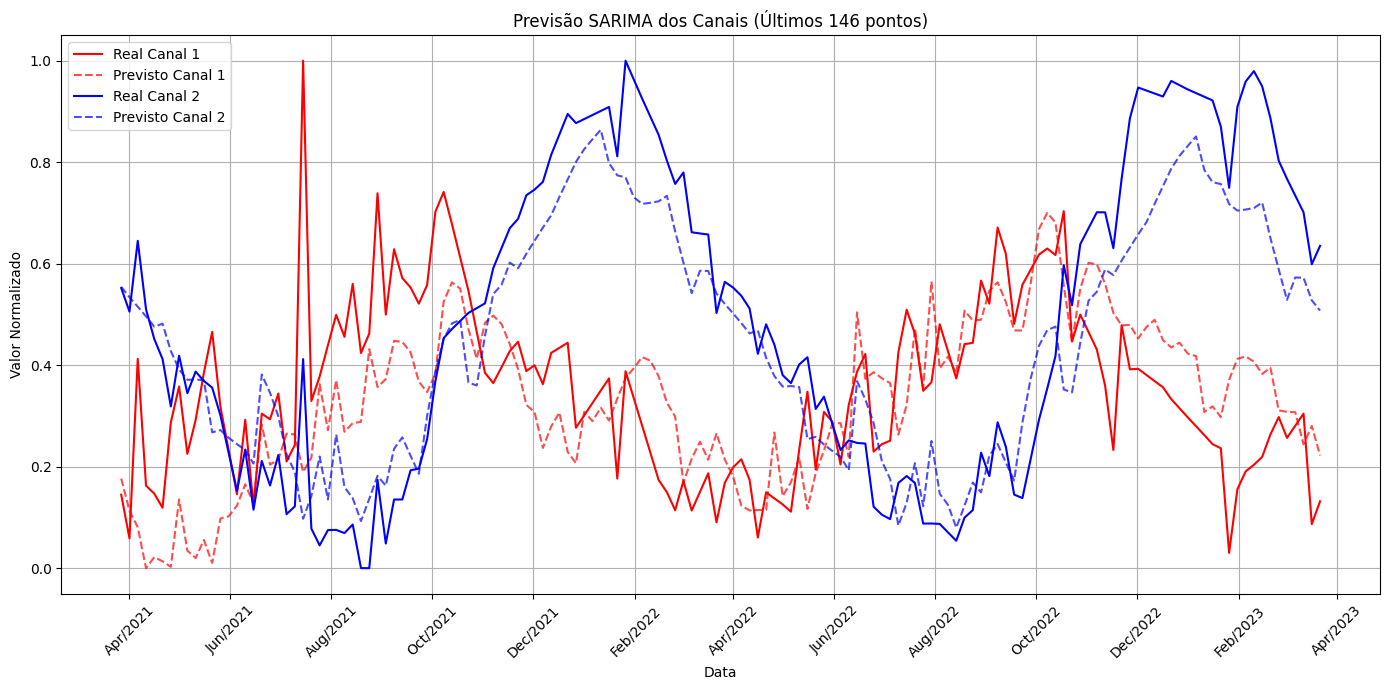

{'Canal 1': {'RMSE': np.float64(165.48336011723774),
  'MAE': 124.34422758084469},
 'Canal 2': {'RMSE': np.float64(202.6585320601818), 'MAE': 166.14408692247486}}

In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def sarima_forecast_avaliacao(datas, serie, sazonalidade=72, steps_a_frente=146):
    datas_dt = [datetime.strptime(date, "%Y_%m_%d") for date in datas]

    intervalo = datas_dt[1] - datas_dt[0]
    datas_futuras = datas_dt[-steps_a_frente:]

    plt.figure(figsize=(14, 7))

    resultados = {}

    for canal_index, cor in zip([0, 1], ['red', 'blue']):
        # Separar treino e teste
        serie_total = serie[:, canal_index]  # Agora serie é um np.array
        serie_treino = serie_total[:-steps_a_frente]
        serie_real = serie_total[-steps_a_frente:]

        # Ajustar modelo
        modelo = SARIMAX(
            serie_treino,
            order=(1, 1, 1),
            seasonal_order=(1, 1, 1, sazonalidade),
            enforce_stationarity=False,
            enforce_invertibility=False
        )

        resultado = modelo.fit(disp=False)
        previsao = resultado.forecast(steps=steps_a_frente)

        # Normalização conjunta (real + previsão)
        valores_para_normalizar = np.concatenate([serie_real, previsao])
        minimo, maximo = valores_para_normalizar.min(), valores_para_normalizar.max()

        serie_real_norm = (serie_real - minimo) / (maximo - minimo)
        previsao_norm = (previsao - minimo) / (maximo - minimo)

        # Métricas
        rmse = np.sqrt(mean_squared_error(serie_real, previsao))
        mae = mean_absolute_error(serie_real, previsao)
        resultados[f"Canal {canal_index+1}"] = {'RMSE': rmse, 'MAE': mae}

        # Plot
        plt.plot(datas_futuras, serie_real_norm, label=f"Real Canal {canal_index+1}", color=cor)
        plt.plot(datas_futuras, previsao_norm, '--', label=f"Previsto Canal {canal_index+1}", color=cor, alpha=0.7)

    plt.title("Previsão SARIMA dos Canais (Últimos 146 pontos)")
    plt.xlabel("Data")
    plt.ylabel("Valor Normalizado")
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return resultados

# Corrija aqui também:
clean = np.array(clean)

# Agora funciona:
sarima_forecast_avaliacao(list(dados.keys()), clean)
